# Credit Risk Modelling – Probability of Default (PD) Model

## Objective
This notebook develops a **Probability of Default (PD)** model using Logistic Regression.
The model estimates the likelihood that a borrower will default on a loan based on demographic, financial, and behavioral variables.

Logistic Regression is widely used in banking due to its:
- Interpretability
- Stability
- Regulatory acceptance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = "../data/processed/credit_model_ready.csv"
df = pd.read_csv(DATA_PATH)

df.head()

,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_missing,Saving accounts_moderate,Saving accounts_quite rich,...,Checking account_moderate,Checking account_rich,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0.146949,-0.745131,-1.236478,True,True,False,True,False,False,...,False,False,False,False,False,False,True,False,False,0
1,-1.191404,0.146949,0.949817,2.248194,False,True,False,False,False,False,...,True,False,False,False,False,False,True,False,False,1
2,1.183312,-1.383771,-0.416562,-0.738668,True,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
3,0.831502,0.146949,1.634247,1.750384,True,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,0
4,1.535122,0.146949,0.566664,0.256953,True,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1


## Feature and Target Separation

In [3]:
X = df.drop(columns=["Risk"])
y = df["Risk"]

print("Feature shape:", X.shape)
print("Target shape:", y.shape)

Feature shape: (1000, 21)
Target shape: (1000,)


## Train-Test Split

A hold-out test set is used to evaluate out-of-sample performance.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(Risk
 0    0.7
 1    0.3
 Name: proportion, dtype: float64,
 Risk
 0    0.7
 1    0.3
 Name: proportion, dtype: float64)

## Logistic Regression Model Training

In [5]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

log_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

## Probability of Default Prediction


In [6]:
y_train_pd = log_model.predict_proba(X_train)[:, 1]
y_test_pd = log_model.predict_proba(X_test)[:, 1]

## Model Performance – AUC-ROC


In [7]:
from sklearn.metrics import roc_auc_score

train_auc = roc_auc_score(y_train, y_train_pd)
test_auc = roc_auc_score(y_test, y_test_pd)

print("Train AUC:", round(train_auc, 3))
print("Test AUC :", round(test_auc, 3))

Train AUC: 0.777
Test AUC : 0.758


## 

The performance of the Probability of Default (PD) model is evaluated using the **Area Under the ROC Curve (AUC)**, which measures the model’s ability to discriminate between defaulters and non-defaulters.

### AUC Results
- **Training AUC:** 0.777  
- **Testing AUC:** 0.758  

The small difference between training and testing AUC indicates **good generalization** and **no significant overfitting**.

## ROC Curve


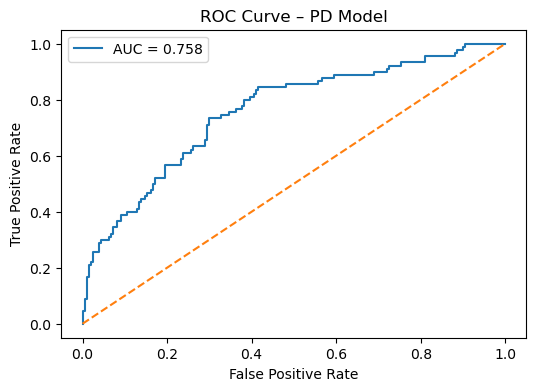

In [8]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pd)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {test_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – PD Model")
plt.legend()
plt.show()

## ROC Curve Interpretation

The ROC curve lies well above the diagonal line representing a random classifier.  
This indicates that the PD model consistently achieves a higher true positive rate than false positive rate across different probability thresholds.

This behavior confirms that the model has **good discriminatory power**, which is the primary objective of PD models used in credit risk assessment.

## Classification Metrics (Threshold = 0.5)

In [9]:
from sklearn.metrics import classification_report

y_pred_class = (y_test_pd >= 0.5).astype(int)

print(classification_report(y_test, y_pred_class))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       210
           1       0.64      0.39      0.48        90

    accuracy                           0.75       300
   macro avg       0.71      0.65      0.66       300
weighted avg       0.73      0.75      0.73       300



## Classification Metrics Interpretation

Classification metrics were computed using a probability threshold of 0.5.

While the overall accuracy is approximately 75%, the recall for default cases is lower.  
This is expected, as PD models are **ranking models**, not binary classifiers.

In real-world banking applications, probability thresholds are chosen based on:
- Risk appetite
- Capital constraints
- Expected loss optimization

Therefore, **AUC is the preferred evaluation metric**, rather than accuracy or recall at a fixed threshold.

## Model Coefficient Interpretation


In [ ]:
coefficients = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_model.coef_[0]
}).sort_values(by="Coefficient", ascending=False)

coefficients

,Feature,Coefficient
16,Purpose_education,0.716407
3,Duration,0.455070
6,Housing_rent,0.231465
19,Purpose_repairs,0.213623
2,Credit amount,-0.001589
1,Job,-0.020015
15,Purpose_domestic appliances,-0.055325
0,Age,-0.074528
14,Purpose_car,-0.132247
8,Saving accounts_moderate,-0.145107


In [11]:
coefficients.head(10)

,Feature,Coefficient
16,Purpose_education,0.716407
3,Duration,0.455070
6,Housing_rent,0.231465
19,Purpose_repairs,0.213623
2,Credit amount,-0.001589
1,Job,-0.020015
15,Purpose_domestic appliances,-0.055325
0,Age,-0.074528
14,Purpose_car,-0.132247
8,Saving accounts_moderate,-0.145107


In [12]:
coefficients.tail(10)

,Feature,Coefficient
12,Checking account_moderate,-0.250962
5,Housing_own,-0.280803
18,Purpose_radio/TV,-0.361138
4,Sex_male,-0.369320
9,Saving accounts_quite rich,-0.393929
20,Purpose_vacation/others,-0.497753
13,Checking account_rich,-0.581040
10,Saving accounts_rich,-0.899331
7,Saving accounts_missing,-0.963422
11,Checking account_missing,-1.620627


## Model Coefficient Interpretation

Logistic Regression coefficients indicate the direction and magnitude of each feature’s impact on default probability:

- **Positive coefficient:** Increases Probability of Default (PD)
- **Negative coefficient:** Decreases Probability of Default (PD)

The magnitude of the coefficient reflects the strength of the relationship with default risk.

### Key Risk-Increasing Factors

The following variables were identified as major contributors to higher default risk:

- **Education-related loan purpose** shows the strongest positive association with default.
- **Longer loan duration** significantly increases default probability due to prolonged repayment exposure.
- **Rental housing status** indicates lower financial stability compared to home ownership.
- **Repair-related loan purposes** may signal financial stress, increasing credit risk.

These variables represent structural and behavioral risk drivers commonly observed in retail credit portfolios.

### Key Risk-Reducing Factors

Several variables were found to significantly reduce default probability:

- **Rich saving account balances** strongly lower PD by providing financial buffers.
- **Strong checking account balances** indicate better liquidity and repayment capacity.
- **Home ownership** reflects higher financial stability.
- **Older age groups** show slightly lower default risk.

These factors align well with established credit risk theory and real-world lending practices.

## Final Summary – Probability of Default Model

A Logistic Regression model was developed to estimate the Probability of Default (PD) using demographic, financial, and behavioral variables.

The model achieved strong and stable performance with a testing AUC of 0.758, indicating good discriminatory power.  
Key drivers of default risk include loan duration, housing status, and specific loan purposes, while liquidity indicators such as saving and checking account balances significantly reduce default probability.

The model is interpretable, stable, and aligned with industry-standard credit risk modeling practices, making it suitable for decision support in retail lending.